<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson3_AdvancedLinreg/ML_AI_Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пример бинаризации признаков

Сгенерируем данные

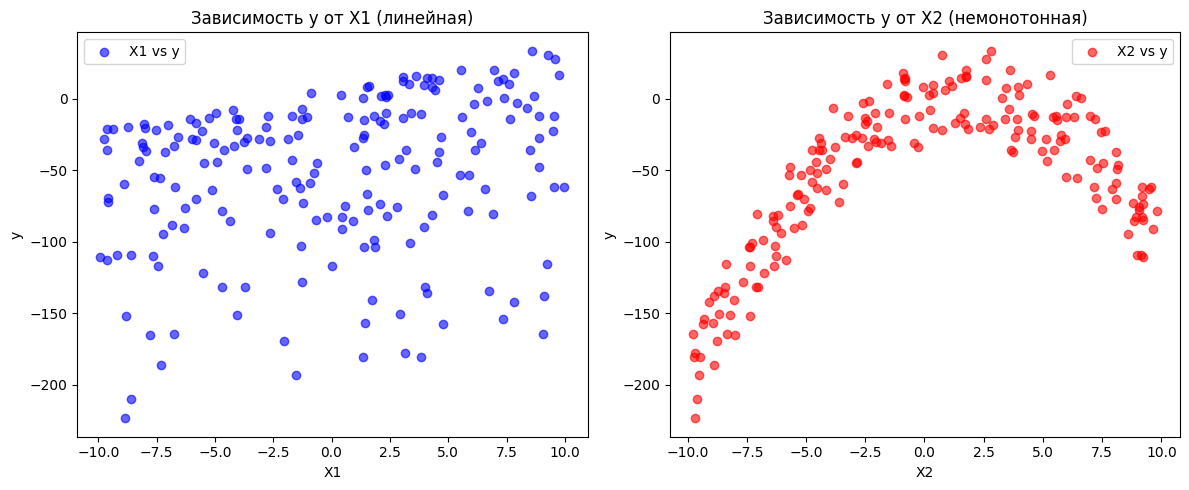

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Параметры
n_samples = 200       # Количество образцов
a = 3.0               # Коэффициент для линейной зависимости
b = 5.0               # Коэффициент для немонотонной зависимости
c = -1.5              # Коэффициент квадратичного члена
noise_std = 5.0       # Стандартное отклонение шума

# Генерация признаков
np.random.seed(0)
X1 = np.random.uniform(-10, 10, n_samples)  # Признак 1 (линейная зависимость с y)
X2 = np.random.uniform(-10, 10, n_samples)  # Признак 2 (немонотонная зависимость с y)

# Генерация целевой переменной
# Линейная часть
y_linear = a * X1

# Нелинейная часть
y_nonlinear = b * X2 + c * X2**2

# Итоговая целевая переменная с шумом
y = y_linear + y_nonlinear + np.random.normal(0, noise_std, n_samples)

# Создание DataFrame для удобства
df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'y': y
})

# Визуализация
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['X1'], df['y'], color='b', alpha=0.6, label='X1 vs y')
plt.xlabel('X1')
plt.ylabel('y')
plt.title('Зависимость y от X1 (линейная)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df['X2'], df['y'], color='r', alpha=0.6, label='X2 vs y')
plt.xlabel('X2')
plt.ylabel('y')
plt.title('Зависимость y от X2 (немонотонная)')
plt.legend()

plt.tight_layout()
plt.show()

Обучим классическую линейную регрессию

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['X1', 'X2']]
y = df['y']

# Разбиение данных на тренировочную и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)

print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.2559


Нужно ли было масштабировать признаки?

## Делаем бинаризацию

In [ ]:
# Используем pd.cut для разбиения X2 на 4 равных интервала
X['X2_cut'] = pd.cut(X['X2'], bins=4, labels=['bin1', 'bin2', 'bin3', 'bin4'])

# Используем pd.qcut для разбиения X2 на 4 квантильных интервала (с примерно одинаковым числом значений в каждом)
#df['X2_qcut'] = pd.qcut(df['X2'], q=4, labels=['quartile1', 'quartile2', 'quartile3', 'quartile4'])

# Выводим первые несколько строк для просмотра результата
print(X[['X2', 'X2_cut']].head())

         X2 X2_cut
0 -3.764082   bin2
1  3.926870   bin3
2 -2.444963   bin2
3 -6.407926   bin1
4 -9.506425   bin1


In [ ]:
# Применяем One-Hot Encoding к столбцу X2_cut и добавляем новые признаки в исходный DataFrame
X = pd.get_dummies(X, columns=['X2_cut'], prefix='X2_cut', drop_first=False)

# Выводим первые несколько строк для проверки
print(X.head())

         X1        X2  X2_cut_bin1  X2_cut_bin2  X2_cut_bin3  X2_cut_bin4
0  0.976270 -3.764082        False         True        False        False
1  4.303787  3.926870        False        False         True        False
2  2.055268 -2.444963        False         True        False        False
3  0.897664 -6.407926         True        False        False        False
4 -1.526904 -9.506425         True        False        False        False


In [ ]:
X.drop('X2', axis=1, inplace=True)

In [ ]:
# Разбиение данных на тренировочную и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)

print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.7585


In [ ]:
model.coef_

array([  2.56541397, -70.45686712,  21.11598361,  47.64722684,
         1.69365667])

Вопросы на внимательность (и не только):

1) где произошел dataleak? И как нужно было сделать правильно?

2) а где еще был dataleak?

## В принципе иногда можно и проще

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Разделение данных на признаки и целевую переменную
X = df[['X1', 'X2']]
y = df['y']

# Разбиение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Создание пайплайна с полиномиальными признаками и стандартизацией
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

# Обучение модели на тренировочных данных
pipeline.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = pipeline.predict(X_test)

# Вычисление R^2 на тестовой выборке
r2 = r2_score(y_test, y_pred)
print(f"R^2 на тестовой выборке: {r2:.4f}")

R^2 на тестовой выборке: 0.9935


In [ ]:
import numpy as np

# Извлекаем имена полиномиальных признаков после обучения пайплайна
feature_names = pipeline.named_steps['poly_features'].get_feature_names_out(input_features=X.columns)

# Извлекаем коэффициенты линейной регрессии из обученного пайплайна
coefficients = pipeline.named_steps['linear_regression'].coef_

# Создаем DataFrame для наглядности
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Сортируем по абсолютному значению коэффициента, чтобы увидеть самые важные признаки
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance[['Feature', 'Coefficient', 'Importance']])

  Feature  Coefficient  Importance
4    X2^2   -42.810204   42.810204
1      X2    29.125103   29.125103
0      X1    17.627359   17.627359
3   X1 X2    -0.368341    0.368341
2    X1^2    -0.313914    0.313914


# Другие функции потерь (начало экспериментов)

In [1]:
!pip install statsmodels

In [128]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Генерация данных
np.random.seed(42)
n_points = 200
x = np.random.uniform(0, 1, n_points)
y = 2.5 * x + 1.0 + np.random.normal(0, 0.5, n_points)  # линейная зависимость с шумом

# Создание DataFrame
data = pd.DataFrame({'x': x, 'y': y})

# Определение признаков и целевой переменной
X = sm.add_constant(data['x'])  # добавляем константу для свободного члена
y = data['y']

In [129]:
X.head()

,const,x
0,1.0,0.374540
1,1.0,0.950714
2,1.0,0.731994
3,1.0,0.598658
4,1.0,0.156019


In [130]:
y_train.shape

(150,)

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [132]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

pred_mse = model.predict(X_test)

r2_score(y_test, pred_mse)

0.6183051009102749

In [133]:
# Указываем квантиль
quantile = 0.5  # медианная регрессия

# Обучение квантильной регрессии
model = sm.QuantReg(y_train, X_train)
quantile_regression = model.fit(q=quantile)

In [134]:
# Прогнозирование на новых данных
pred_mae = quantile_regression.predict(X_test)
print(pred_mae[:10])

95     2.305636
15     1.570303
30     2.575114
158    1.698784
128    1.152278
115    3.200345
69     3.473796
170    2.740994
174    2.664257
45     2.705359
dtype: float64


In [135]:
from sklearn.metrics import r2_score

r2_score(y_test, pred_mae)

0.6217081480258181

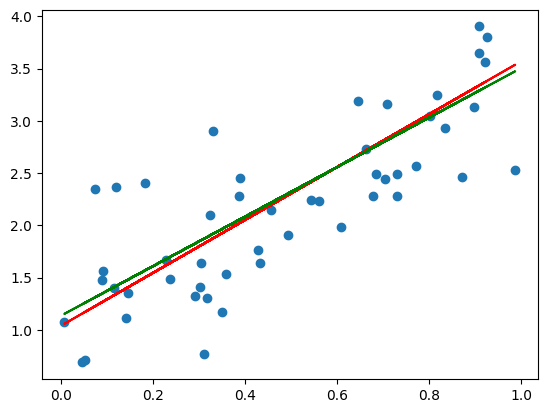

In [136]:
from matplotlib import pyplot as plt

plt.scatter(X_test['x'], y_test)
plt.plot(X_test['x'], pred_mse, c='red')
plt.plot(X_test['x'], pred_mae, c='green')

In [143]:
model = sm.QuantReg(y_train, X_train)
quantile_regression = model.fit(q=0.4)

pred_quant = quantile_regression.predict(X_test)

r2_score(y_test, pred_quant)

0.6374762670120104